In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from string import punctuation
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input , Dense , Embedding  , Dropout , LayerNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [ ]:
df = pd.read_csv("drive/MyDrive/Projects/Grammar_Correction/test_dataset_csv")

In [ ]:
df.head()

,incorrect,correct
0,"Bitcoin is for $7,094 this morning, which Coin...","Bitcoin goes for $7,094 this morning, accordin..."
1,The effect of widespread dud targets two face ...,"1. The effect of ""widespread dud"" targets two ..."
2,tax on sales of stores for non residents are s...,Capital Gains tax on the sale of properties fo...
3,Much many brands and sellers still in the market.,Many brands and sellers still in the market.
4,this is is the latest Maintenance release of S...,This is is the latest maintenance release of S...


In [ ]:
def remove_extra_spaces(text):

    text = re.sub(r" '(\w)",r"'\1",text)
    text = re.sub(r" \,",",",text)
    text = re.sub(r" \.+",".",text)
    text = re.sub(r" \!+","!",text)
    text = re.sub(r" \?+","?",text)
    text = re.sub(" n't","n't",text)
    text = re.sub("[\(\)\;\_\^\`\/]","",text)

    return text

In [ ]:
def remove_contractions(text):

  contraction_patterns = [
        (r"won\'t", "will not"),
        (r"can\'t", "can not"),
        (r"n\'t", " not"),
        (r"\'re", " are"),
        (r"\'s", " is"),
        (r"\'d", " would"),
        (r"\'ll", " will"),
        (r"\'t", " not"),
        (r"\'ve", " have"),
        (r"\'m", " am")
    ]

  for pattern, replacement in contraction_patterns:
        text = re.sub(pattern, replacement, text)

  return text

In [ ]:
def text_preprocessing(df, col):



    df[col] = df[col].astype(str)
    df[col] = df[col].apply(lambda x: x.lower())
    df[col] = df[col].apply(lambda x: re.sub("\n", "", x))
    df[col] = df[col].apply(lambda x: remove_extra_spaces(x))
    df[col] = df[col].apply(lambda x: re.sub(r"\.+", ".", x))
    df[col] = df[col].apply(lambda x: re.sub(r"\!+", "!", x))
    df[col] = df[col].apply(lambda x: remove_contractions(x))
    df[col] = df[col].apply(lambda x: re.sub("[^A-Za-z\s]", "", x))
    df[col] = df[col].apply(lambda x: x.strip())


    if col == "incorrect":
        df[col] = df[col].apply(lambda x: re.sub(r'\d', '', x))
    elif col == "correct":
        df[col] = df[col].apply(lambda x: re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,।]", "", x))
        df[col] = df[col].apply(lambda x: re.sub(r'\s+', ' ', x))

    return df

In [ ]:
df = text_preprocessing(df,"incorrect")
df = text_preprocessing(df,"correct")

In [ ]:
df.head()

,incorrect,correct
0,bitcoin is for this morning which coindesk says,bitcoin goes for this morning according to coi...
1,the effect of widespread dud targets two face ...,the effect of widespread dud targets two face ...
2,tax on sales of stores for non residents are s...,capital gains tax on the sale of properties fo...
3,much many brands and sellers still in the market,many brands and sellers still in the market
4,this is is the latest maintenance release of s...,this is is the latest maintenance release of s...


In [ ]:
def add_sos_eos(df,col):
  df[col] = "<sos> " + df[col] + " <eos>"
  return df

In [ ]:
df = add_sos_eos(df,"correct")

In [ ]:
df.head()

,incorrect,correct
0,bitcoin is for this morning which coindesk says,<sos> bitcoin goes for this morning according ...
1,the effect of widespread dud targets two face ...,<sos> the effect of widespread dud targets two...
2,tax on sales of stores for non residents are s...,<sos> capital gains tax on the sale of propert...
3,much many brands and sellers still in the market,<sos> many brands and sellers still in the mar...
4,this is is the latest maintenance release of s...,<sos> this is is the latest maintenance releas...


In [ ]:
df['length_incorr'] = [len(text.split()) for text in df["incorrect"]]
df['length_corr'] = [len(text.split()) for text in df["correct"]]

In [ ]:
df.head()

,incorrect,correct,length_incorr,length_corr
0,bitcoin is for this morning which coindesk says,<sos> bitcoin goes for this morning according ...,8,10
1,the effect of widespread dud targets two face ...,<sos> the effect of widespread dud targets two...,15,17
2,tax on sales of stores for non residents are s...,<sos> capital gains tax on the sale of propert...,55,61
3,much many brands and sellers still in the market,<sos> many brands and sellers still in the mar...,9,10
4,this is is the latest maintenance release of s...,<sos> this is is the latest maintenance releas...,9,11


In [ ]:
df = df[~(df['length_incorr'] < 5) & ~(df['length_incorr'] > 20)]
df = df[~(df['length_corr'] < 5) & ~(df['length_corr'] > 20)]

In [ ]:
df.head()

,incorrect,correct,length_incorr,length_corr
0,bitcoin is for this morning which coindesk says,<sos> bitcoin goes for this morning according ...,8,10
1,the effect of widespread dud targets two face ...,<sos> the effect of widespread dud targets two...,15,17
3,much many brands and sellers still in the market,<sos> many brands and sellers still in the mar...,9,10
4,this is is the latest maintenance release of s...,<sos> this is is the latest maintenance releas...,9,11
6,watcch as this dodge challenger hellcat gets s...,<sos> watch as this dodge challenger hellcat g...,17,19


In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def remove_sos_eos(sentence):
    return sentence.replace('<sos>', '').replace('<eos>', '')


correct_words = df[df['length_corr'] > df['length_incorr']]['correct'].apply(remove_sos_eos).str.split().explode().value_counts().head(10)
incorrect_words = df[df['length_corr'] < df['length_incorr']]['incorrect'].apply(remove_sos_eos).str.split().explode().value_counts().head(10)

<ipython-input-19-61e1cf277074>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=correct_words.values, x=correct_words.index, palette='viridis')
<ipython-input-19-61e1cf277074>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=incorrect_words.values, x=incorrect_words.index, palette='viridis')


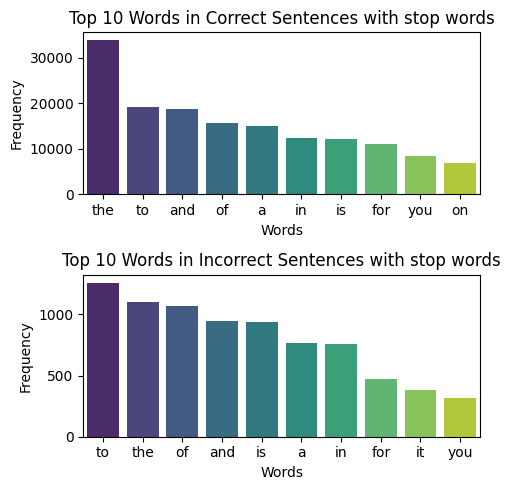

In [ ]:
plt.figure(figsize=(5,5))
plt.subplot(2,1,1)
sns.barplot(y=correct_words.values, x=correct_words.index, palette='viridis')
plt.title('Top 10 Words in Correct Sentences with stop words')
plt.ylabel('Frequency')
plt.xlabel('Words')

plt.subplot(2,1,2)
sns.barplot(y=incorrect_words.values, x=incorrect_words.index, palette='viridis')
plt.title('Top 10 Words in Incorrect Sentences with stop words')
plt.ylabel('Frequency')
plt.xlabel('Words')

plt.tight_layout()
plt.show()

In [ ]:
def without_stop(sentence):
    stop_words = set(stopwords.words('english'))
    sentence = sentence.replace('<sos>', '').replace('<eos>', '')
    words = sentence.split()
    words = [word for word in words if word.lower() not in stop_words]
    return words

correct_words = df[df['length_corr'] > df['length_incorr']]['correct'].apply(without_stop).explode().value_counts().head(10)
incorrect_words = df[df['length_corr'] < df['length_incorr']]['incorrect'].apply(without_stop).explode().value_counts().head(10)

<ipython-input-21-204c670fd75f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=correct_words.values, x=correct_words.index, palette='viridis')
<ipython-input-21-204c670fd75f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=incorrect_words.values, x=incorrect_words.index, palette='viridis')


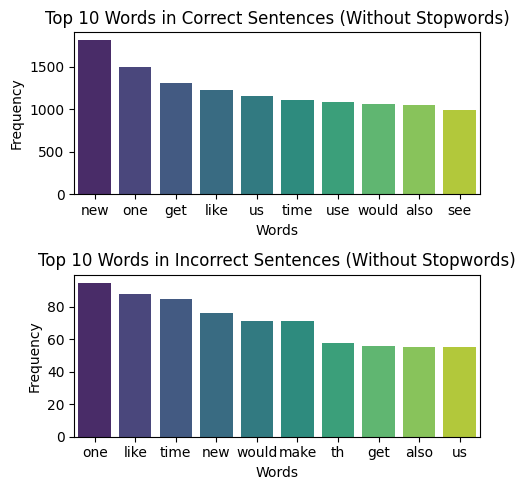

In [ ]:
plt.figure(figsize=(5,5))
plt.subplot(2, 1, 1)
sns.barplot(y=correct_words.values, x=correct_words.index, palette='viridis')
plt.title('Top 10 Words in Correct Sentences (Without Stopwords)')
plt.ylabel('Frequency')
plt.xlabel('Words')

plt.subplot(2, 1, 2)
sns.barplot(y=incorrect_words.values, x=incorrect_words.index, palette='viridis')
plt.title('Top 10 Words in Incorrect Sentences (Without Stopwords)')
plt.ylabel('Frequency')
plt.xlabel('Words')

plt.tight_layout()
plt.show()

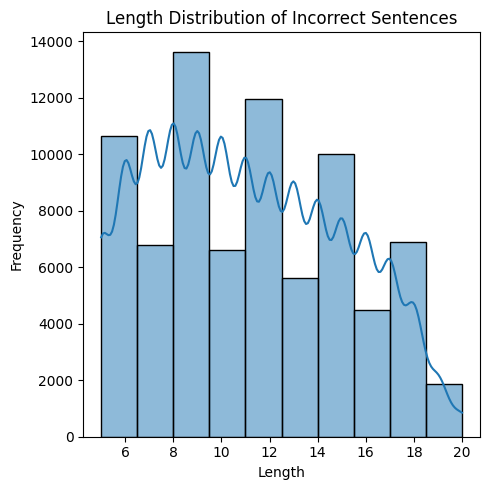

In [ ]:
plt.figure(figsize=(5,5))
sns.histplot(df['length_incorr'], bins=10, kde=True)
plt.title('Length Distribution of Incorrect Sentences')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

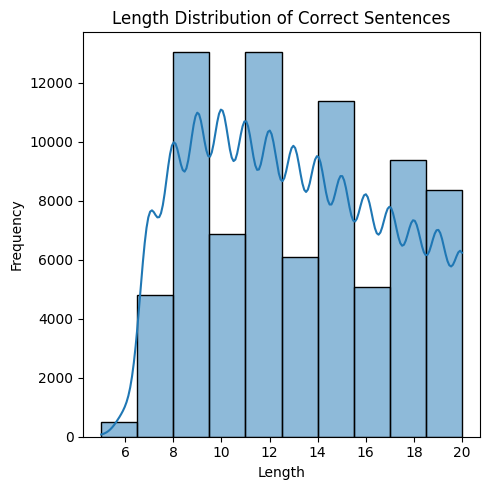

In [ ]:
plt.figure(figsize=(5,5))
sns.histplot(df['length_corr'], bins=10, kde=True)
plt.title('Length Distribution of Correct Sentences')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
def generate_wordcloud(text,title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(5, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
df['clean_incorrect'] = df['incorrect'].apply(without_stop)
df['clean_correct'] = df['correct'].apply(without_stop)

In [ ]:
df['clean_incorrect'] = df['clean_incorrect'].apply(' '.join)
df['clean_correct'] = df['clean_correct'].apply(' '.join)

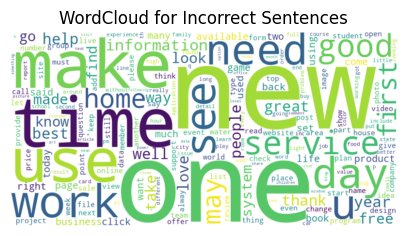

In [ ]:
incorrect_text = ' '.join(df['clean_incorrect'])
generate_wordcloud(incorrect_text,"WordCloud for Incorrect Sentences")

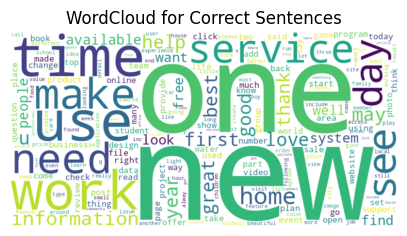

In [ ]:
correct_text = ' '.join(df['clean_correct'])
generate_wordcloud(correct_text,"WordCloud for Correct Sentences")

In [ ]:
input_tokenizer = Tokenizer(oov_token = "<OOV>" ,filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')
input_tokenizer.fit_on_texts(df["incorrect"])

In [ ]:
input_tokenizer.word_index["<pad>"] = 0
input_tokenizer.index_word[0] = "<pad>"

In [ ]:
target_tokenizer = Tokenizer(oov_token = "<OOV>" ,filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')
target_tokenizer.fit_on_texts(df["correct"])

In [ ]:
target_tokenizer.word_index["<pad>"] = 0
target_tokenizer.index_word[0] = "<pad>"

In [ ]:
inputs = input_tokenizer.texts_to_sequences(df["incorrect"])
targets = target_tokenizer.texts_to_sequences(df["correct"])

In [ ]:
inputs[0],targets[0]

([3968, 6, 9, 16, 861, 53, 27275, 660],
 [2, 3557, 1159, 11, 18, 843, 674, 5, 26376, 3])

In [ ]:
inputs = pad_sequences(inputs,maxlen=20,padding="post")
targets = pad_sequences(targets,maxlen=20,padding="post")

In [ ]:
inputs[0],targets[0]

(array([ 3968,     6,     9,    16,   861,    53, 27275,   660,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0], dtype=int32),
 array([    2,  3557,  1159,    11,    18,   843,   674,     5, 26376,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0], dtype=int32))

In [ ]:
input_vocab_size = len(input_tokenizer.word_index)
target_vocab_size = len(target_tokenizer.word_index)

In [ ]:
input_vocab_size,target_vocab_size

(87137, 68302)

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(inputs , targets , test_size=0.2 , random_state = 42)

In [ ]:
batch_size = 128
buffer_size = 1000

train_set = tf.data.Dataset.from_tensor_slices((X_train , y_train))
train_set = train_set.shuffle(buffer_size).batch(batch_size , drop_remainder = True)

test_set = tf.data.Dataset.from_tensor_slices((X_test , y_test))
test_set = test_set.batch(batch_size , drop_remainder = True)

In [ ]:
len(train_set),len(test_set)

(490, 122)

In [ ]:
def angles(pos , idx , embedding_dim) :
    rates = 1 / np.power(10000 , (2 * (idx // 2)) / np.float32(embedding_dim))

    return pos * rates

In [ ]:
def positional_encoding(position , embedding_dim) :

    angle_rads = angles(np.arange(position)[:, np.newaxis],
                           np.arange(embedding_dim)[np.newaxis, :], embedding_dim)


    angle_rads[: , 0::2] = np.sin(angle_rads[: , 0::2])


    angle_rads[: , 1::2] = np.cos(angle_rads[: , 1::2])

    pos_encoding  = angle_rads = angle_rads[np.newaxis , ...]

    return tf.cast(pos_encoding , dtype = tf.float32)

In [ ]:
pos_encodings = positional_encoding(20, 32)

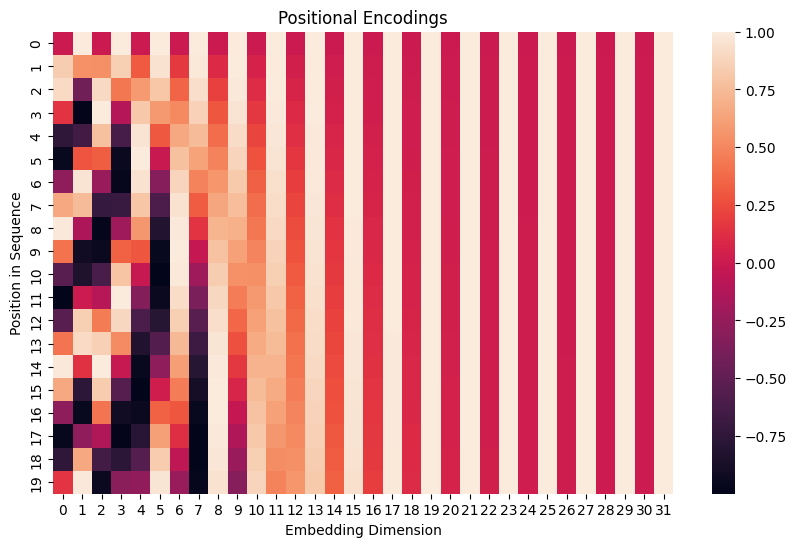

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(pos_encodings[0])
plt.xlabel('Embedding Dimension')
plt.ylabel('Position in Sequence')
plt.title('Positional Encodings')
plt.show()

In [ ]:
def create_padding_mask(seq) :
    seq = tf.cast(tf.math.equal(seq , 0) , tf.float32)

    return seq[: , tf.newaxis , tf.newaxis , :]

In [ ]:
def create_look_ahead_mask(size) :
    mask = 1 - tf.linalg.band_part(tf.ones((size , size)) , -1 , 0)

    return mask

In [ ]:
def create_masks(src , trg) :

    enc_padding_mask = create_padding_mask(src)
    dec_padding_mask = create_padding_mask(src)

    look_ahead_mask = create_look_ahead_mask(tf.shape(trg)[1])

    dec_trg_padding_mask = create_padding_mask(trg)

    combined_mask = tf.maximum(dec_trg_padding_mask , look_ahead_mask)

    return enc_padding_mask , combined_mask , dec_padding_mask

In [ ]:
def SelfAttention(q , k , v , mask) :

    attention_logits = tf.matmul(q , k , transpose_b=True)

    scaling =  tf.math.sqrt(tf.cast(tf.shape(k)[-1] , dtype = tf.float32))


    scaled_attention_logits = attention_logits / scaling
    if mask is not None :
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits , axis = -1)

    output = tf.matmul(attention_weights , v)

    return output , attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer) :
    def __init__(self , embedding_dim , num_heads) :
        super(MultiHeadAttention , self).__init__()

        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

        assert self.embedding_dim % self.num_heads == 0


        self.head_dim = self.embedding_dim // self.num_heads

        self.queries = Dense(embedding_dim)
        self.keys = Dense(embedding_dim)
        self.values = Dense(embedding_dim)
        self.fc_out = Dense(embedding_dim)

    def split_heads(self , x , batch_size) :
        x = tf.reshape(x , (batch_size , -1 , self.num_heads , self.head_dim))
        return tf.transpose(x , perm = [0 , 2 , 1 , 3])

    def call(self , q , k , v , mask = None) :
        batch_size = tf.shape(q)[0]

        q = self.queries(q)
        k = self.keys(k)
        v = self.values(v)

        q = self.split_heads(q , batch_size)
        k = self.split_heads(k , batch_size)
        v = self.split_heads(v , batch_size)

        scaled_attention , attention_weights = SelfAttention(q , k , v , mask)

        scaled_attention = tf.transpose(scaled_attention , perm = [0 , 2 , 1 , 3])


        attention_output = tf.reshape(scaled_attention , (batch_size , -1 , self.embedding_dim))

        out = self.fc_out(attention_output)

        return out , attention_weights

In [ ]:
def FC(embedding_dim , fc_dim) :
    model = tf.keras.Sequential([
        Dense(fc_dim , activation = 'relu') ,
        Dense(embedding_dim)
    ])

    return model

In [ ]:
class EncoderBlock(tf.keras.layers.Layer) :
    def __init__(self , embedding_dim , num_heads , fc_dim , dropout_rate = 0.1) :
        super(EncoderBlock , self).__init__()

        self.MHA = MultiHeadAttention(embedding_dim , num_heads)

        self.fc = FC(embedding_dim , fc_dim)

        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self , x , training , mask) :

        attn_out , _ = self.MHA(x , x , x , mask)
        attn_out = self.dropout1(attn_out , training = training)

        out1 = self.norm1(x + attn_out)

        fc_out = self.dropout2(self.fc(out1) , training = training)

        enc_out = self.norm2(out1 + fc_out)

        return enc_out

In [ ]:
class Encoder(tf.keras.layers.Layer) :
    def __init__(
        self ,
        num_layers ,
        embedding_dim ,
        num_heads ,
        fc_dim ,
        src_vocab_size ,
        max_length ,
        dropout_rate = 0.1
    ) :
        super(Encoder , self).__init__()

        self.num_layers = num_layers
        self.embedding_dim = embedding_dim

        self.embedding = Embedding(src_vocab_size , embedding_dim)
        self.pos_encoding = positional_encoding(max_length , embedding_dim)

        self.enc_layers = [EncoderBlock(embedding_dim , num_heads , fc_dim , dropout_rate)
                          for _ in range(num_layers)]

        self.dropout = Dropout(dropout_rate)

    def call(self , x , training , mask) :
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        x += self.pos_encoding[: , :seq_len , :]
        x = self.dropout(x , training = training)

        for i in range(self.num_layers) :
            x = self.enc_layers[i](x , training , mask)

        return x

In [ ]:
class DecoderBlock(tf.keras.layers.Layer) :
    def __init__(self , embedding_dim , num_heads , fc_dim , dropout_rate = 0.1) :
        super(DecoderBlock , self).__init__()

        self.MHA1 = MultiHeadAttention(embedding_dim , num_heads)
        self.MHA2 = MultiHeadAttention(embedding_dim , num_heads)

        self.fc = FC(embedding_dim , fc_dim)

        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.norm3 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)

    def call(self , x , enc_output , training , look_ahead_mask , padding_mask) :


        attn1 , attnW1 = self.MHA1(x , x , x , look_ahead_mask)
        attn1 = self.dropout1(attn1 , training = training)
        out1 = self.norm1(attn1 + x)

        attn2 , attnW2 = self.MHA2(out1 , enc_output , enc_output , padding_mask)
        attn2 = self.dropout2(attn2 , training = training)
        out2 = self.norm2(attn2 + out1)

        fc_out = self.dropout3(self.fc(out2) , training = training)

        dec_out = self.norm3(fc_out + out2)

        return dec_out , attnW1 , attnW2

In [ ]:
class Decoder(tf.keras.layers.Layer) :
    def __init__(
        self ,
        num_layers ,
        embedding_dim ,
        num_heads ,
        fc_dim ,
        trg_vocab_size ,
        max_length ,
        dropout_rate = 0.1
    ) :
        super(Decoder , self).__init__()

        self.num_layers = num_layers
        self.embedding_dim = embedding_dim

        self.embedding = Embedding(trg_vocab_size , embedding_dim)
        self.pos_encoding = positional_encoding(max_length , embedding_dim)

        self.dec_layers = [DecoderBlock(embedding_dim , num_heads , fc_dim , dropout_rate)
                          for _ in range(num_layers)]

        self.dropout = Dropout(dropout_rate)

    def call(self , x , enc_output , training , look_ahead_mask , padding_mask) :
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        x += self.pos_encoding[: , :seq_len , :]
        x = self.dropout(x , training = training)

        for i in range(self.num_layers) :
            x , attnW1 , attnW2 = self.dec_layers[i](x , enc_output , training , look_ahead_mask , padding_mask)


        attention_weights['decoder_layer{}_block1'.format(i+1)] = attnW1
        attention_weights['decoder_layer{}_block2'.format(i+1)] = attnW2

        return x, attention_weights

In [ ]:
class Transformer(Model) :
    def __init__(
        self ,
        num_layers ,
        embedding_dim ,
        num_heads ,
        fc_dim ,
        src_vocab_size ,
        trg_vocab_size ,
        src_max_length ,
        trg_max_length ,
        dropout_rate = 0.1
    ) :
        super(Transformer , self).__init__()

        self.encoder = Encoder(
            num_layers ,
            embedding_dim ,
            num_heads ,
            fc_dim ,
            src_vocab_size ,
            src_max_length ,
            dropout_rate
        )

        self.decoder = Decoder(
            num_layers ,
            embedding_dim ,
            num_heads ,
            fc_dim ,
            trg_vocab_size ,
            trg_max_length ,
            dropout_rate
        )

        self.fc_out = Dense(trg_vocab_size)

    def call(
        self ,
        src ,
        trg ,
        training ,
        enc_padding_mask ,
        look_ahead_mask ,
        dec_padding_mask
    ) :

        enc_output = self.encoder(src , training , enc_padding_mask)

        dec_output , attention_weights = self.decoder(
                            trg , enc_output , training , look_ahead_mask, dec_padding_mask)

        out = self.fc_out(dec_output)

        return out , attention_weights

In [ ]:
EPOCHS = 100
EMBEDDING_DIM = 256
FC_DIM = 512
NUM_LAYERS = 4
NUM_HEADS = 8
DROPOUT_RATE = 0.1
SRC_VOCAB_SIZE = len(input_tokenizer.word_index)
TRG_VOCAB_SIZE = len(target_tokenizer.word_index)
SRC_MAXLEN = SRC_VOCAB_SIZE
TRG_MAXLEN = TRG_VOCAB_SIZE

model = Transformer(
    NUM_LAYERS ,
    EMBEDDING_DIM ,
    NUM_HEADS ,
    FC_DIM ,
    SRC_VOCAB_SIZE ,
    TRG_VOCAB_SIZE ,
    SRC_MAXLEN ,
    TRG_MAXLEN ,
    DROPOUT_RATE
)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule) :
    def __init__(self , embedding_dim , warmup_steps = 4000) :
        super(CustomSchedule , self).__init__()

        self.embedding_dim = tf.cast(embedding_dim , dtype = tf.float32)
        self.warmup_steps = tf.cast(warmup_steps , dtype = tf.float32)

    def __call__(self , step) :
        step = tf.cast(step , dtype = tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.embedding_dim) * tf.math.minimum(arg1 , arg2)

In [ ]:
LR = CustomSchedule(EMBEDDING_DIM)

optimizer = Adam(LR, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def criterion(real , pred) :

    mask = tf.math.logical_not(tf.math.equal(real , 0))

    loss = loss_object(real , pred)

    mask = tf.cast(mask , dtype = loss.dtype)

    loss *= mask

    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

In [ ]:
@tf.function
def train_step(src , trg) :
    decoder_input = trg[: , :-1]
    trg_reals = trg[: , 1:]

    enc_padding_mask , combined_mask , dec_padding_mask = create_masks(src , decoder_input)

    with tf.GradientTape() as tape :
        preds , _ = model(
            src ,
            decoder_input ,
            True ,
            enc_padding_mask ,
            combined_mask ,
            dec_padding_mask
        )

        loss = criterion(trg_reals , preds)

    gradients = tape.gradient(loss , model.trainable_variables)
    optimizer.apply_gradients(zip(gradients , model.trainable_variables))

    train_loss(loss)


@tf.function
def val_step(src , trg) :
    decoder_input = trg[: , :-1]
    trg_reals = trg[: , 1:]

    enc_padding_mask , combined_mask , dec_padding_mask = create_masks(src , decoder_input)

    preds , _ = model(
        src ,
        decoder_input ,
        False ,
        enc_padding_mask ,
        combined_mask ,
        dec_padding_mask
    )

    loss = criterion(trg_reals , preds)

    val_loss(loss)

In [ ]:
with tf.device("/GPU:0") :
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(EPOCHS)) :
        train_loss.reset_states()
        val_loss.reset_states()

        for src , trg in train_set :
            train_step(src , trg)

        for src , trg in test_set :
            val_step(src , trg)

        train_losses.append(train_loss.result())
        val_losses.append(val_loss.result())

        if (epoch + 1) % 10 == 0 :
            print(f"\n[Epoch :  {epoch+1}/{EPOCHS}] [Train Loss : {train_losses[-1]:0.2f}] [Validation Loss : {val_losses[-1]:0.2f}]\n")

  0%|          | 0/100 [00:00<?, ?it/s]


[Epoch :  10/100] [Train Loss : 1.90] [Validation Loss : 3.13]


[Epoch :  20/100] [Train Loss : 0.71] [Validation Loss : 3.49]


[Epoch :  30/100] [Train Loss : 0.37] [Validation Loss : 3.82]


[Epoch :  40/100] [Train Loss : 0.27] [Validation Loss : 4.06]


[Epoch :  50/100] [Train Loss : 0.25] [Validation Loss : 4.09]



In [ ]:
def evalute(sent) :
    sentence = input_tokenizer.texts_to_sequences([sent])
    sentence = pad_sequences(sentence , maxlen = 20 , padding = 'post')

    input = tf.convert_to_tensor(np.array(sentence) , dtype = tf.int64)

    decoder_input = label_tokenizer.texts_to_sequences(['sos'])
    decoder_input = tf.convert_to_tensor(np.array(decoder_input) , dtype = tf.int64)

    for i in range(20) :
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(input, decoder_input)

        preds , _ = model(
            input ,
            decoder_input ,
            False ,
            enc_padding_mask ,
            combined_mask ,
            dec_padding_mask
        )

        preds = preds[: , -1: , :]
        predicted_id = tf.cast(tf.argmax(preds, axis=-1), tf.int64)

        if predicted_id == label_tokenizer.word_index['eos'] :
            return tf.squeeze(decoder_input , axis = 0)

        decoder_input = tf.concat([decoder_input, predicted_id], axis=1)

    return tf.squeeze(decoder_input, axis=0)

In [ ]:
test_sample = df.sample(1000)

In [ ]:
x_test = test_sample['incorrect'].tolist()
y_test = test_sample['correct'].tolist()

In [ ]:
acc = 0

result = []

for i in range(int(len(x_test)/10)):
  a = evalute(x_test[i])
  pred_sent = ' '.join([label_tokenizer.index_word[idx] for idx in a.numpy() if idx != 0 and idx != 2])
  result.append(pred_sent)

In [ ]:
cleaned_sentences = [sentence.replace('<sos>', '').replace('<eos>', '').strip() for sentence in y_test[:100]]

In [ ]:
def accuracy(preds, labels):
    num_correct = sum(1 for pred, label in zip(preds, labels) if pred == label)
    return num_correct / len(preds)


def evaluate_grammar_correction_model(predicted_sentences, corrected_sentences):

    acc = accuracy(predicted_sentences, corrected_sentences)


    return acc * 100.0

acc = evaluate_grammar_correction_model(result, cleaned_sentences)
print("Model Accuracy:", acc)